In [1]:
import os
import sys
import yaml
import math
import pickle
import itertools
from copy import deepcopy

module_path = os.path.abspath(os.path.join('../../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from collections import defaultdict

from bson.objectid import ObjectId
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl

import src.utils.numpy_nest_utils as np_nest
from src.utils.sacred_retrieval import SacredExperimentAccess, get_dicts_key_subset, get_unique_dicts, flatten_dict
from experiments.dispatch.dispatch_utils import nested_dict_to_option_strings

# plotting
%config InlineBackend.figure_formats = ['svg']

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preview'] = True
# mpl.rcParams['grid.linewidth']=0.2
mpl.rcParams['lines.linewidth']=0.7
# mpl.rcParams['axes.linewidth']=0.001
mpl.rcParams['figure.dpi'] = 300

font = {'family' : 'times',
        'weight' : 'bold',
        'size'   : 10}

mpl.rc('font', **font)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + plt.rcParams['axes.prop_cycle'].by_key()['color']
text_width = 5.5

# Comparison of two distributed VI mehtods, and their privatised counterparts

In [2]:
def combine_configs(*configs):
    ret = {}
    for config in configs:
        ret = {**ret, **config}
    return ret

homo_configs = [ {'privacy_settings.sigma_relative': 5, 'privacy_settings.max_epsilon': val, 'dataset_dist.client_size_factor': 0, 'dataset_dist.class_balance_factor': 0} for val in [None, 0.5, 1.0, 2.0, 3.0]]
inhomo_1_configs = [ {'privacy_settings.sigma_relative': 5, 'privacy_settings.max_epsilon': val, 'dataset_dist.client_size_factor': 0.9, 'dataset_dist.class_balance_factor': 0.95} for val in [None, 0.5, 1.0, 2.0, 3.0]]
inhomo_2_configs = [ {'privacy_settings.sigma_relative': 5, 'privacy_settings.max_epsilon': val, 'dataset_dist.client_size_factor': 0.9, 'dataset_dist.class_balance_factor': 0} for val in [None, 0.5, 1.0, 2.0, 3.0]]

dp_pvi_configs = {'experiment_tag': 'datapoint_dp_pvi'}
dp_batch_vi_configs = {'experiment_tag': 'dp_batch_vi'}
pvi_configs = {'experiment_tag': 'pvi'}
batch_vi_configs = {'experiment_tag': 'batch_vi'}

dp_pvi_homo_configs = [combine_configs(c1, c2) for c1, c2 in itertools.product([dp_pvi_configs], homo_configs)]
dp_pvi_inhomo_1_configs = [combine_configs(c1, c2) for c1, c2 in itertools.product([dp_pvi_configs], inhomo_1_configs)]
dp_pvi_inhomo_2_configs = [combine_configs(c1, c2) for c1, c2 in itertools.product([dp_pvi_configs], inhomo_2_configs)]

dp_batch_vi_homo_configs = [combine_configs(c1, c2) for c1, c2 in itertools.product([dp_batch_vi_configs], homo_configs)]
dp_batch_vi_inhomo_1_configs = [combine_configs(c1, c2) for c1, c2 in itertools.product([dp_batch_vi_configs], inhomo_1_configs)]
dp_batch_vi_inhomo_2_configs = [combine_configs(c1, c2) for c1, c2 in itertools.product([dp_batch_vi_configs], inhomo_2_configs)]

pvi_homo_configs = [combine_configs(c1, c2) for c1, c2 in itertools.product([pvi_configs], [{'dataset_dist.client_size_factor': 0, 'dataset_dist.class_balance_factor': 0}])]
pvi_inhomo_1_configs = [combine_configs(c1, c2) for c1, c2 in itertools.product([pvi_configs], [{'dataset_dist.client_size_factor': 0.9, 'dataset_dist.class_balance_factor': 0.95}])]
pvi_inhomo_2_configs = [combine_configs(c1, c2) for c1, c2 in itertools.product([pvi_configs], [{'dataset_dist.client_size_factor': 0.9, 'dataset_dist.class_balance_factor': 0}])]

batch_vi_homo_configs = [combine_configs(c1, c2) for c1, c2 in itertools.product([batch_vi_configs], [{'dataset_dist.client_size_factor': 0, 'dataset_dist.class_balance_factor': 0}])]
batch_vi_inhomo_1_configs = [combine_configs(c1, c2) for c1, c2 in itertools.product([batch_vi_configs], [{'dataset_dist.client_size_factor': 0.9, 'dataset_dist.class_balance_factor': 0.95}])]
batch_vi_inhomo_2_configs = [combine_configs(c1, c2) for c1, c2 in itertools.product([batch_vi_configs], [{'dataset_dist.client_size_factor': 0.9, 'dataset_dist.class_balance_factor': 0}])]

In [3]:
dp_pvi_configs

{'experiment_tag': 'datapoint_dp_pvi'}

In [4]:
results_access = SacredExperimentAccess(database_name='epsilon_clipping_adult_0709')

In [5]:
dp_pvi_homo_experiments = [results_access.get_experiments(complete=True, config=config) for config in dp_pvi_homo_configs]
dp_pvi_inhomo_1_experiments = [results_access.get_experiments(complete=True, config=config) for config in dp_pvi_inhomo_1_configs]
dp_pvi_inhomo_2_experiments = [results_access.get_experiments(complete=True, config=config) for config in dp_pvi_inhomo_2_configs]

dp_batch_vi_homo_experiments = [results_access.get_experiments(complete=True, config=config) for config in dp_batch_vi_homo_configs]
dp_batch_vi_inhomo_1_experiments = [results_access.get_experiments(complete=True, config=config) for config in dp_batch_vi_inhomo_1_configs]
dp_batch_vi_inhomo_2_experiments = [results_access.get_experiments(complete=True, config=config) for config in dp_batch_vi_inhomo_2_configs]

dp_pvi_homo_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "test_all", *[f"client_{i}.MomentAccountant.epsilon" for i in range(10)]]) for experiments in dp_pvi_homo_experiments]
dp_pvi_inhomo_1_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "test_all", *[f"client_{i}.MomentAccountant.epsilon" for i in range(10)]]) for experiments in dp_pvi_inhomo_1_experiments]
dp_pvi_inhomo_2_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "test_all", *[f"client_{i}.MomentAccountant.epsilon" for i in range(10)]]) for experiments in dp_pvi_inhomo_2_experiments]

dp_batch_vi_homo_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "test_all", *[f"client_{i}.MomentAccountant.epsilon" for i in range(10)]]) for experiments in dp_batch_vi_homo_experiments]
dp_batch_vi_inhomo_1_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "test_all", *[f"client_{i}.MomentAccountant.epsilon" for i in range(10)]]) for experiments in dp_batch_vi_inhomo_1_experiments]
dp_batch_vi_inhomo_2_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "test_all", *[f"client_{i}.MomentAccountant.epsilon" for i in range(10)]]) for experiments in dp_batch_vi_inhomo_2_experiments]

pvi_homo_experiments = [results_access.get_experiments(complete=True, config=config) for config in pvi_homo_configs]
pvi_inhomo_1_experiments = [results_access.get_experiments(complete=True, config=config) for config in pvi_inhomo_1_configs]
pvi_inhomo_2_experiments = [results_access.get_experiments(complete=True, config=config) for config in pvi_inhomo_2_configs]

batch_vi_homo_experiments = [results_access.get_experiments(complete=True, config=config) for config in batch_vi_homo_configs]
batch_vi_inhomo_1_experiments = [results_access.get_experiments(complete=True, config=config) for config in batch_vi_inhomo_1_configs]
batch_vi_inhomo_2_experiments = [results_access.get_experiments(complete=True, config=config) for config in batch_vi_inhomo_2_configs]

pvi_homo_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "test_all"]) for experiments in pvi_homo_experiments]
pvi_inhomo_1_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "test_all"]) for experiments in pvi_inhomo_1_experiments]
pvi_inhomo_2_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "test_all"]) for experiments in pvi_inhomo_2_experiments]

batch_vi_homo_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "test_all"]) for experiments in batch_vi_homo_experiments]
batch_vi_inhomo_1_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "test_all"]) for experiments in batch_vi_inhomo_1_experiments]
batch_vi_inhomo_2_metrics = [results_access.get_metrics_by_exp(experiments, ["test_accuracy", "test_all"]) for experiments in batch_vi_inhomo_2_experiments]

In [6]:
# all_homo_configs = [*dp_pvi_homo_configs, *dp_batch_vi_homo_configs]
# all_inhomo_1_configs = [*dp_pvi_inhomo_1_configs, *dp_batch_vi_inhomo_1_configs]
# all_inhomo_2_configs = [*dp_pvi_inhomo_2_configs, *dp_batch_vi_inhomo_2_configs]

# all_homo_experiments = [*dp_pvi_homo_experiments, *dp_batch_vi_homo_experiments]
# all_inhomo_1_experiments = [*dp_pvi_inhomo_1_experiments, *dp_batch_vi_inhomo_1_experiments]
# all_inhomo_2_experiments = [*dp_pvi_inhomo_2_experiments, *dp_batch_vi_inhomo_2_experiments]

# all_homo_metrics = [*dp_pvi_homo_metrics, *dp_batch_vi_homo_metrics]
# all_inhomo_1_metrics = [*dp_pvi_inhomo_1_metrics, *dp_batch_vi_inhomo_1_metrics]
# all_inhomo_2_metrics = [*dp_pvi_inhomo_2_metrics, *dp_batch_vi_inhomo_2_metrics]

all_homo_configs = [*dp_pvi_homo_configs, *pvi_homo_configs, *batch_vi_homo_configs, *dp_batch_vi_homo_configs]
all_inhomo_1_configs = [*dp_pvi_inhomo_1_configs, *pvi_inhomo_1_configs, *batch_vi_inhomo_1_configs, *dp_batch_vi_inhomo_1_configs]
all_inhomo_2_configs = [*dp_pvi_inhomo_2_configs, *pvi_inhomo_2_configs, *batch_vi_inhomo_2_configs, *dp_batch_vi_inhomo_2_configs]

all_homo_experiments = [*dp_pvi_homo_experiments, *pvi_homo_experiments, *batch_vi_homo_experiments, *dp_batch_vi_homo_experiments]
all_inhomo_1_experiments = [*dp_pvi_inhomo_1_experiments, *pvi_inhomo_1_experiments, *batch_vi_inhomo_1_experiments, *dp_batch_vi_inhomo_1_experiments]
all_inhomo_2_experiments = [*dp_pvi_inhomo_2_experiments, *pvi_inhomo_2_experiments, *batch_vi_inhomo_2_experiments, *dp_batch_vi_inhomo_2_experiments]

all_homo_metrics = [*dp_pvi_homo_metrics, *pvi_homo_metrics, *batch_vi_homo_metrics, *dp_batch_vi_homo_metrics]
all_inhomo_1_metrics = [*dp_pvi_inhomo_1_metrics, *pvi_inhomo_1_metrics, *batch_vi_inhomo_1_metrics, *dp_batch_vi_inhomo_1_metrics]
all_inhomo_2_metrics = [*dp_pvi_inhomo_2_metrics, *pvi_inhomo_2_metrics, *batch_vi_inhomo_2_metrics, *dp_batch_vi_inhomo_2_metrics]

In [7]:
for c, e, m in zip(dp_pvi_homo_configs, dp_pvi_homo_experiments, dp_pvi_homo_metrics):
    print(c, len(e), len(m))
    print('***')

{'experiment_tag': 'datapoint_dp_pvi', 'privacy_settings.sigma_relative': 5, 'privacy_settings.max_epsilon': None, 'dataset_dist.client_size_factor': 0, 'dataset_dist.class_balance_factor': 0} 5 5
***
{'experiment_tag': 'datapoint_dp_pvi', 'privacy_settings.sigma_relative': 5, 'privacy_settings.max_epsilon': 0.5, 'dataset_dist.client_size_factor': 0, 'dataset_dist.class_balance_factor': 0} 5 5
***
{'experiment_tag': 'datapoint_dp_pvi', 'privacy_settings.sigma_relative': 5, 'privacy_settings.max_epsilon': 1.0, 'dataset_dist.client_size_factor': 0, 'dataset_dist.class_balance_factor': 0} 5 5
***
{'experiment_tag': 'datapoint_dp_pvi', 'privacy_settings.sigma_relative': 5, 'privacy_settings.max_epsilon': 2.0, 'dataset_dist.client_size_factor': 0, 'dataset_dist.class_balance_factor': 0} 5 5
***
{'experiment_tag': 'datapoint_dp_pvi', 'privacy_settings.sigma_relative': 5, 'privacy_settings.max_epsilon': 3.0, 'dataset_dist.client_size_factor': 0, 'dataset_dist.class_balance_factor': 0} 0 0
***

In [8]:
for c, e, m in zip(dp_pvi_inhomo_1_configs, dp_pvi_inhomo_1_configs, dp_pvi_homo_metrics):
    print(c, len(e), len(m))
    print('***')

{'experiment_tag': 'datapoint_dp_pvi', 'privacy_settings.sigma_relative': 5, 'privacy_settings.max_epsilon': None, 'dataset_dist.client_size_factor': 0.9, 'dataset_dist.class_balance_factor': 0.95} 5 5
***
{'experiment_tag': 'datapoint_dp_pvi', 'privacy_settings.sigma_relative': 5, 'privacy_settings.max_epsilon': 0.5, 'dataset_dist.client_size_factor': 0.9, 'dataset_dist.class_balance_factor': 0.95} 5 5
***
{'experiment_tag': 'datapoint_dp_pvi', 'privacy_settings.sigma_relative': 5, 'privacy_settings.max_epsilon': 1.0, 'dataset_dist.client_size_factor': 0.9, 'dataset_dist.class_balance_factor': 0.95} 5 5
***
{'experiment_tag': 'datapoint_dp_pvi', 'privacy_settings.sigma_relative': 5, 'privacy_settings.max_epsilon': 2.0, 'dataset_dist.client_size_factor': 0.9, 'dataset_dist.class_balance_factor': 0.95} 5 5
***
{'experiment_tag': 'datapoint_dp_pvi', 'privacy_settings.sigma_relative': 5, 'privacy_settings.max_epsilon': 3.0, 'dataset_dist.client_size_factor': 0.9, 'dataset_dist.class_balan

In [9]:
def plot_methods_comms_rounds(configs, experiments, metrics, metric_num=0, title=None):
    plt.figure(figsize=(text_width,text_width/1.5))
    
    y_label = ""
    for i, (config, expeiment, metric) in enumerate(zip(configs, experiments, metrics)):
        if not len(metric) == 0:
            values = []
            y_label=f'{metric[0][metric_num]["name"]}'.replace('_', ' ')
            for m in metric:
                values.append(m[metric_num]['values'])
            values = np.array(values).T
            steps = np.array(metric[0][metric_num]['steps'])
            
            mean = np.mean(values, axis=1)
            std = np.std(values, axis=1)
            
            if 'privacy_settings' in expeiment[0]["config"]:
                label = f'{expeiment[0]["config"]["experiment_tag"]}: max $\epsilon$ {expeiment[0]["config"]["privacy_settings"]["max_epsilon"]}'.replace('_', ' ')
            else:
                label = f'{expeiment[0]["config"]["experiment_tag"]}'.replace('_', ' ')
                
            #             plt.plot(steps, values, color=colors[i], label=f'max $\epsilon$ {expeiment[0]["config"]["privacy_settings"]["max_epsilon"]}: {np.max(values):0.3f}'.replace('_', ' '))              
            plt.plot(steps, mean, color=colors[i], label=label)
            plt.fill_between(steps, mean - std, mean + std, color=colors[i], alpha=0.2)
            
    if title is not None:
        plt.title(title)
    plt.grid('on')
    plt.xlabel('Communication rounds')
    plt.ylabel(y_label)
    plt.legend()

In [10]:
def plot_epsilons(configs, experiments, metrics, epsilon_metric_indicies=[0], title=None):
    plt.figure(figsize=(text_width,text_width/1.5))
    
    for i, (config, expeiment, metric) in enumerate(zip(configs, experiments, metrics)):
        if not len(metric) == 0:
            values = []
            for m in metric:
                for e_i in epsilon_metric_indicies:
                    values.append(m[e_i]['values'])
            values = np.array(values).T
            steps = np.atleast_2d(np.array(metric[0][epsilon_metric_indicies[0]]['steps'])).T

            plt.plot(steps, values, color=colors[i % len(colors)], label=f'max $\epsilon$ {expeiment[0]["config"]["privacy_settings"]["max_epsilon"]}: {np.max(values):0.3f}'.replace('_', ' '))
            
    if title is not None:
        plt.title(title)
    plt.grid('on')
    plt.xlabel('Communication rounds')
    plt.ylabel('epsilon')
    plt.legend()

In [11]:
def plot_methods_eps(configs, experiments, metrics, metric_num=0, epsilon_metric_indicies=[0], title=None):
    plt.figure(figsize=(text_width,text_width/1.5))
    
    y_label = ""
    for i, (config, expeiment, metric) in enumerate(zip(configs, experiments, metrics)):
        if not len(metric) == 0:
            y_label=f'{metric[0][metric_num]["name"]}'.replace('_', ' ')
            values = []
            for m in metric:
                values.append(m[metric_num]['values'])
                eps = []
                for e_i in epsilon_metric_indicies:
                    e = []
                    for step in m[metric_num]['steps']:
                        e.append(m[e_i]['values'][m[e_i]['steps'].index(step)])
                    eps.append(e)
                eps = np.max(eps, axis=0)
                values = np.array(values).T
                plt.plot(eps, values, color=colors[i], label=f'max $\epsilon$ {expeiment[0]["config"]["privacy_settings"]["max_epsilon"]}: {np.max(values):0.3f}'.replace('_', ' '))
            
    if title is not None:
        plt.title(title)
    plt.grid('on')
    plt.xlabel('epsilon')
    plt.ylabel(y_label)
    plt.legend()

In [12]:
def plot_methods_eps_final_only(configs, experiments, metrics, metric_num=0, epsilon_metric_indicies=[0], title=None):
    plt.figure(figsize=(text_width,text_width/1.5))
    
    y_label = ""
    for i, (config, expeiment, metric) in enumerate(zip(configs, experiments, metrics)):
        if not len(metric) == 0:
            y_label=f'{metric[0][metric_num]["name"]}'.replace('_', ' ')
            values = []
            eps = []
            for m in metric:
                run_values = m[metric_num]['values'] # run metirc values
                run_epsilons = []
                for e_i in epsilon_metric_indicies:
                    run_epsilons.append(np.max(m[e_i]['values'])) # max epsilon for each client in the run
                        
                values.append(np.max(run_values)) # add the best metric/epsilon pair to the group
                eps.append(np.max(run_epsilons))
            plt.scatter(eps, values, color=colors[i], label=f'max $\epsilon$ {expeiment[0]["config"]["privacy_settings"]["max_epsilon"]}: {np.max(values):0.3f}'.replace('_', ' '))
            
    if title is not None:
        plt.title(title)
    plt.grid('on')
    plt.xlabel('epsilon')
    plt.ylabel(y_label)
    plt.legend()

No handles with labels found to put in legend.


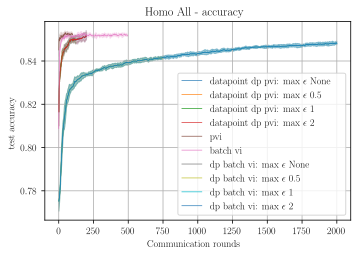

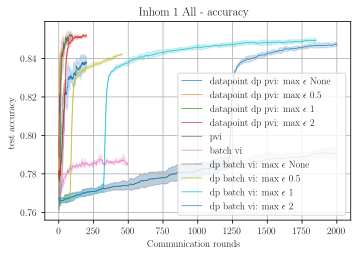

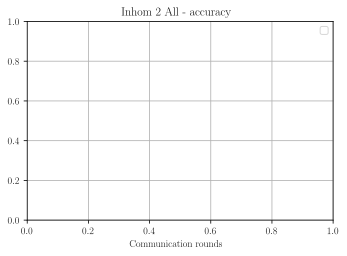

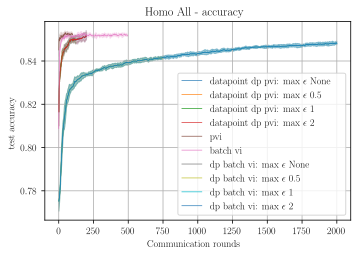

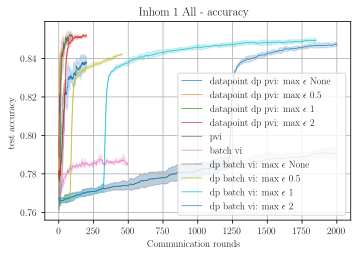

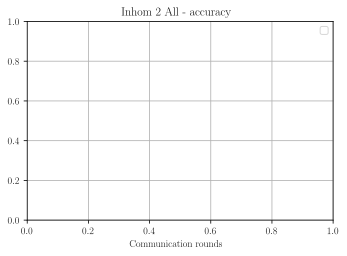

In [13]:
# plot_methods_comms_rounds(dp_pvi_homo_configs, dp_pvi_homo_experiments, dp_pvi_homo_metrics, title='Homo DP-PVI - accuracy')
# plt.ylim([0.75, 0.85])
# plot_methods_comms_rounds(dp_pvi_inhomo_1_configs, dp_pvi_inhomo_1_experiments, dp_pvi_inhomo_1_metrics, title='Inhom 1 DP-PVI - accuracy')
# plt.ylim([0.75, 0.85])
# plot_methods_comms_rounds(dp_pvi_inhomo_2_configs, dp_pvi_inhomo_2_experiments, dp_pvi_inhomo_2_metrics, title='Inhom 2 DP-PVI - accuracy')
# plt.ylim([0.75, 0.85])

# plot_methods_comms_rounds(dp_batch_vi_homo_configs, dp_batch_vi_homo_experiments, dp_batch_vi_homo_metrics, title='Homo DP Batch VI - accuracy')
# plt.ylim([0.75, 0.85])
# plot_methods_comms_rounds(dp_batch_vi_inhomo_1_configs, dp_batch_vi_inhomo_1_experiments, dp_batch_vi_inhomo_1_metrics, title='Inhom 1 DP Batch VI - accuracy')
# plt.ylim([0.75, 0.85])
# plot_methods_comms_rounds(dp_batch_vi_inhomo_2_configs, dp_batch_vi_inhomo_2_experiments, dp_batch_vi_inhomo_2_metrics, title='Inhom 2 DP Batch VI - accuracy')
# plt.ylim([0.75, 0.85])

plot_methods_comms_rounds(all_homo_configs, all_homo_experiments, all_homo_metrics, title='Homo All - accuracy')
# plt.ylim([0.82, 0.86])
# plt.xlim([0, 200])
plot_methods_comms_rounds(all_inhomo_1_configs, all_inhomo_1_experiments, all_inhomo_1_metrics, title='Inhom 1 All - accuracy')
# plt.ylim([0.82, 0.86])
# plt.xlim([0, 200])
plot_methods_comms_rounds(all_inhomo_2_configs, all_inhomo_2_experiments, all_inhomo_2_metrics, title='Inhom 2 All - accuracy')
# plt.ylim([0.70, 0.86])
# plt.xlim([0, 200])

No handles with labels found to put in legend.


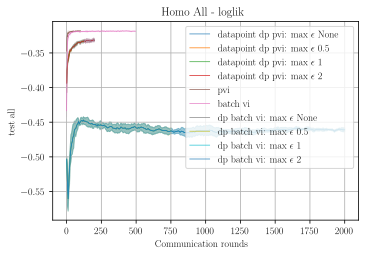

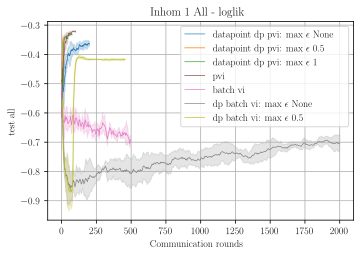

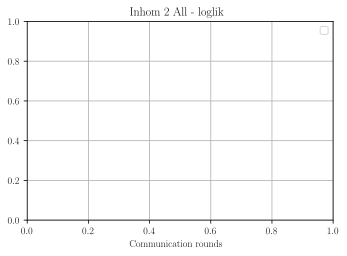

In [14]:
# plot_methods_comms_rounds(dp_pvi_homo_configs, dp_pvi_homo_experiments, dp_pvi_homo_metrics, metric_num=1, title='Homo DP-PVI - loglik')
# # plt.ylim([0.75, 0.85])
# plot_methods_comms_rounds(dp_pvi_inhomo_1_configs, dp_pvi_inhomo_1_experiments, dp_pvi_inhomo_1_metrics, metric_num=1, title='Inhom 1 DP-PVI - loglik')
# # plt.ylim([0.75, 0.85])
# plot_methods_comms_rounds(dp_pvi_inhomo_2_configs, dp_pvi_inhomo_2_experiments, dp_pvi_inhomo_2_metrics, metric_num=1, title='Inhom 2 DP-PVI - loglik')
# # plt.ylim([0.75, 0.85])

# plot_methods_comms_rounds(dp_batch_vi_homo_configs, dp_batch_vi_homo_experiments, dp_batch_vi_homo_metrics, metric_num=1, title='Homo DP Batch VI - loglik')
# # plt.ylim([0.75, 0.85])
# plot_methods_comms_rounds(dp_batch_vi_inhomo_1_configs, dp_batch_vi_inhomo_1_experiments, dp_batch_vi_inhomo_1_metrics, metric_num=1, title='Inhom 1 DP Batch VI - loglik')
# # plt.ylim([0.75, 0.85])
# plot_methods_comms_rounds(dp_batch_vi_inhomo_2_configs, dp_batch_vi_inhomo_2_experiments, dp_batch_vi_inhomo_2_metrics, metric_num=1, title='Inhom 2 DP Batch VI - loglik')
# # plt.ylim([0.75, 0.85])

plot_methods_comms_rounds(all_homo_configs, all_homo_experiments, all_homo_metrics, metric_num=1, title='Homo All - loglik')
# plt.ylim([0.75, 0.85])
# plt.xlim([0, 200])
plot_methods_comms_rounds(all_inhomo_1_configs, all_inhomo_1_experiments, all_inhomo_1_metrics, metric_num=1, title='Inhom 1 All - loglik')
# plt.ylim([0.75, 0.85])
# plt.xlim([0, 200])
plot_methods_comms_rounds(all_inhomo_2_configs, all_inhomo_2_experiments, all_inhomo_2_metrics, metric_num=1, title='Inhom 2 All - loglik')
# plt.ylim([0.75, 0.85])
# plt.xlim([0, 200])

No handles with labels found to put in legend.
No handles with labels found to put in legend.


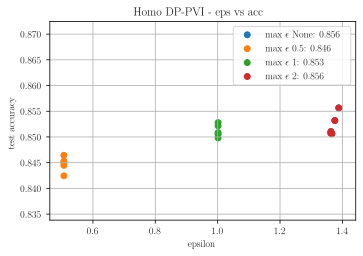

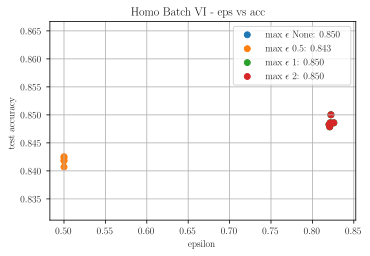

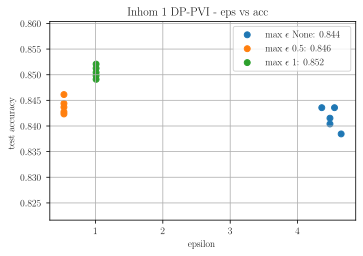

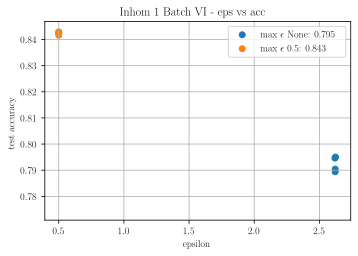

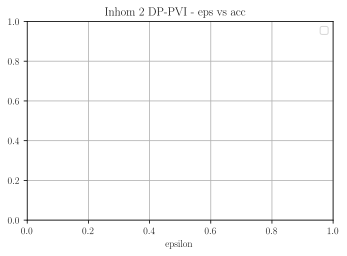

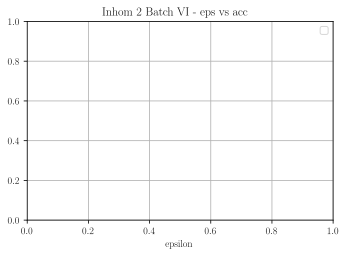

In [16]:
plot_methods_eps_final_only(dp_pvi_homo_configs, dp_pvi_homo_experiments, dp_pvi_homo_metrics, metric_num=0, epsilon_metric_indicies=[i+2 for i in range(10)], title='Homo DP-PVI - eps vs acc')
plot_methods_eps_final_only(dp_batch_vi_homo_configs, dp_batch_vi_homo_experiments, dp_batch_vi_homo_metrics, metric_num=0, epsilon_metric_indicies=[i+2 for i in range(10)], title='Homo Batch VI - eps vs acc')

plot_methods_eps_final_only(dp_pvi_inhomo_1_configs, dp_pvi_inhomo_1_experiments, dp_pvi_inhomo_1_metrics, metric_num=0, epsilon_metric_indicies=[i+2 for i in range(10)], title='Inhom 1 DP-PVI - eps vs acc')
plot_methods_eps_final_only(dp_batch_vi_inhomo_1_configs, dp_batch_vi_inhomo_1_experiments, dp_batch_vi_inhomo_1_metrics, metric_num=0, epsilon_metric_indicies=[i+2 for i in range(10)], title='Inhom 1 Batch VI - eps vs acc')

plot_methods_eps_final_only(dp_pvi_inhomo_2_configs, dp_pvi_inhomo_2_experiments, dp_pvi_inhomo_2_metrics, metric_num=0, epsilon_metric_indicies=[i+2 for i in range(10)], title='Inhom 2 DP-PVI - eps vs acc')
plot_methods_eps_final_only(dp_batch_vi_inhomo_2_configs, dp_batch_vi_inhomo_2_experiments, dp_batch_vi_inhomo_2_metrics, metric_num=0, epsilon_metric_indicies=[i+2 for i in range(10)], title='Inhom 2 Batch VI - eps vs acc')

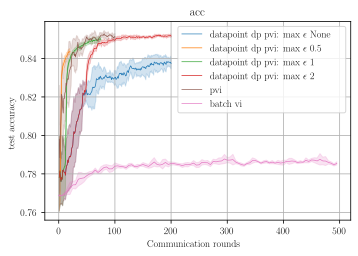

In [18]:
inhomo_1_configs = [*dp_pvi_inhomo_1_configs, *pvi_inhomo_1_configs, *batch_vi_inhomo_1_configs]
inhomo_1_experiments = [*dp_pvi_inhomo_1_experiments, *pvi_inhomo_1_experiments, *batch_vi_inhomo_1_experiments]
inhomo_1_metrics = [*dp_pvi_inhomo_1_metrics, *pvi_inhomo_1_metrics, *batch_vi_inhomo_1_metrics]

plot_methods_comms_rounds(inhomo_1_metrics, inhomo_1_experiments, inhomo_1_metrics, title='acc')